In [1]:
%load_ext tensorboard

In [3]:
import numpy as np
import pandas as pd
import re
#import emot 
#from emot import EMOTICONS_EMO
import nltk
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import datetime, os

In [4]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/validation_data.csv')
target = pd.read_csv('dataset/comments_to_score.csv')
sample = pd.read_csv('dataset/sample_submission.csv')

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train['y'] = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) > 0
train.drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], inplace=True, axis=1)

In [7]:
train.head()

,id,comment_text,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False


In [8]:
train.y.unique()

array([False,  True])

<AxesSubplot:>

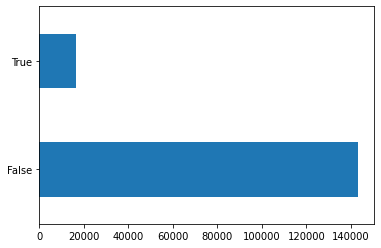

In [9]:
train.y.value_counts().plot(kind='barh')

In [10]:
count_of_toxic_comments =  train[train.y != 0].shape[0]
count_of_toxic_comments

16225

In [11]:
train_toxic = train[train.y != 0]
train_non_toxic = train[train.y == 0].sample(count_of_toxic_comments)

In [12]:
df = pd.concat([train_toxic, train_non_toxic])
df

,id,comment_text,y
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,True
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",True
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,True
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",True
...,...,...,...
96360,036ac588de682671,"By the way, I had no problem translating only ...",False
75013,c8b61837a86e9d66,"""\n\n Concern \n\nI'm concerned of all the use...",False
12327,20ae5843d010d39b,Turkey 14 March 2003 \n\nI'd say the situation...,False
45960,7ace2915af79a67d,"""\n """"Dominion"""" was not used to to indicate ""...",False


<AxesSubplot:>

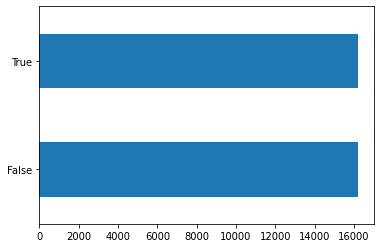

In [13]:
df.y.value_counts().plot(kind='barh')

In [14]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
96360,036ac588de682671,"By the way, I had no problem translating only ...",False,17,15,9,4.470588,92,2
75013,c8b61837a86e9d66,"""\n\n Concern \n\nI'm concerned of all the use...",False,55,47,26,4.581818,315,19
12327,20ae5843d010d39b,Turkey 14 March 2003 \n\nI'd say the situation...,False,43,38,21,4.627907,243,6
45960,7ace2915af79a67d,"""\n """"Dominion"""" was not used to to indicate ""...",False,43,31,19,5.348837,275,16
135692,d5af1baae5529b2e,"I sent a message, with respect.",False,6,6,3,4.333333,31,2


In [15]:
# #Spelling correction
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
# #     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

# df["comment_text"]= df["comment_text"].apply(correct_spellings)

In [16]:
df.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
count,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000
mean,60.719045,41.483082,27.470663,5.047528,353.107581,15.235593
std,102.330680,49.356023,46.673799,15.192434,602.180079,60.885434
min,1.000000,1.000000,0.000000,1.000000,8.000000,0.000000
25%,14.000000,12.000000,5.000000,4.214286,77.000000,3.000000
50%,30.000000,26.000000,13.000000,4.605263,169.000000,7.000000
75%,64.000000,51.000000,30.000000,5.030147,366.000000,15.000000
max,1411.000000,480.000000,902.000000,1655.000000,5000.000000,4942.000000


In [17]:
# Remove stopwords & convert to lower case
#df['comment_text'] = df['comment_text'].apply(lambda text: remove_stopwords(text))
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

In [18]:
# Remove Punctuations
df["comment_text"] = df['comment_text'].str.replace('[^\w\s]','')

<ipython-input-18-188543086b1c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["comment_text"] = df['comment_text'].str.replace('[^\w\s]','')


In [19]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
96360,036ac588de682671,way problem translating sole sentence rather e...,False,8,8,0,6.125000,56,0
75013,c8b61837a86e9d66,concern concerned userboxes deleted en masse ...,False,27,27,2,5.962963,189,0
12327,20ae5843d010d39b,turkey 14 march 2003 say situation fits defini...,False,22,22,0,5.954545,152,0
45960,7ace2915af79a67d,dominion used indicate semiindependent selfgo...,False,22,18,0,7.363636,185,0
135692,d5af1baae5529b2e,sent message respect,False,3,3,0,6.000000,20,0


In [20]:
#Removal of emojis

In [21]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df["comment_text"]= df["comment_text"].apply(lambda string : remove_emoji(string))

In [22]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
96360,036ac588de682671,way problem translating sole sentence rather e...,False,8,8,0,6.125000,56,0
75013,c8b61837a86e9d66,concern concerned userboxes deleted en masse ...,False,27,27,2,5.962963,189,0
12327,20ae5843d010d39b,turkey 14 march 2003 say situation fits defini...,False,22,22,0,5.954545,152,0
45960,7ace2915af79a67d,dominion used indicate semiindependent selfgo...,False,22,18,0,7.363636,185,0
135692,d5af1baae5529b2e,sent message respect,False,3,3,0,6.000000,20,0


In [23]:
#URL removal
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


df["comment_text"]= df["comment_text"].apply(lambda text : remove_urls(text))

In [24]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
96360,036ac588de682671,way problem translating sole sentence rather e...,False,8,8,0,6.125000,56,0
75013,c8b61837a86e9d66,concern concerned userboxes deleted en masse ...,False,27,27,2,5.962963,189,0
12327,20ae5843d010d39b,turkey 14 march 2003 say situation fits defini...,False,22,22,0,5.954545,152,0
45960,7ace2915af79a67d,dominion used indicate semiindependent selfgo...,False,22,18,0,7.363636,185,0
135692,d5af1baae5529b2e,sent message respect,False,3,3,0,6.000000,20,0


In [25]:
#Stemming

In [26]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["comment_text"] = df["comment_text"].apply(lambda text: stem_words(text))

In [27]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
96360,036ac588de682671,way problem translat sole sentenc rather entir...,False,8,8,0,5.500000,51,0
75013,c8b61837a86e9d66,concern concern userbox delet en mass tonight ...,False,27,26,2,5.148148,165,0
12327,20ae5843d010d39b,turkey 14 march 2003 say situat fit definit da...,False,22,22,0,5.000000,131,0
45960,7ace2915af79a67d,dominion use indic semiindepend selfgovern ter...,False,22,18,0,6.454545,163,0
135692,d5af1baae5529b2e,sent messag respect,False,3,3,0,5.666667,19,0


In [28]:
X = df.drop(['y'], axis=1)
y = df['y']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [30]:
X_train.head()

,id,comment_text,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
76690,cd64e48fc4b0d0bf,quot you dumb bastard realli understand anyth,7,7,1,5.571429,45,0
88218,ebf77e3298407a4d,persib persib again pleas leav true fuck you m...,25,19,2,5.400000,159,0
118013,766997bfc92e84cc,hate you hate you,4,2,2,3.500000,17,0
25691,440449ec911108db,seri 13 section vagu section need expans chang...,14,10,0,4.857143,81,0
71352,bf01285eec9b3811,loser loserthat atheisty total lostno guidanc ...,27,27,1,5.814815,183,0


In [31]:
X_train = X_train.comment_text.values
X_test = X_test.comment_text.values

In [32]:
y_train.head()

76690      True
88218      True
118013     True
25691     False
71352      True
Name: y, dtype: bool

In [33]:
OOV_TOKEN = '<OOV>'
VOCAB_SIZE = 10000
MAX_LEN = 120
EMBEDDING_DIM = 100

In [34]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE,oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

In [35]:
len(tokenizer.word_index)

52101

In [36]:
unique_token_count = len(tokenizer.word_counts) + 2

In [37]:
train_seq = tokenizer.texts_to_sequences(X_train)

In [38]:
test_seq = tokenizer.texts_to_sequences(X_test)

In [39]:
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post')

In [40]:
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=MAX_LEN, dtype='int32', padding='post',truncating='post')

In [41]:
test_padded.shape

(8113, 120)

In [42]:
n_features = X.shape[1]

In [43]:
n_features 

8

In [44]:
#Training

In [45]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(0.001)

In [46]:
def create_mlp_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(unique_token_count, 16),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (n_features,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(1),
    ])

In [47]:
def train_model():

  model = create_mlp_model()
  model.compile(loss='mean_squared_error',optimizer=optimizer,
                metrics=['accuracy'])
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  model.fit(train_padded,y = y_train,validation_data=(test_padded, y_test), epochs=100, batch_size=128, verbose = 2, shuffle=True, validation_split=0.2,callbacks=[tensorboard_callback])
  return model

model = train_model()

Epoch 1/100
153/153 - 6s - loss: 0.2244 - accuracy: 0.6529 - val_loss: 0.1351 - val_accuracy: 0.8303
Epoch 2/100
153/153 - 2s - loss: 0.1161 - accuracy: 0.8541 - val_loss: 0.1075 - val_accuracy: 0.8652
Epoch 3/100
153/153 - 2s - loss: 0.0710 - accuracy: 0.9257 - val_loss: 0.0980 - val_accuracy: 0.8700
Epoch 4/100
153/153 - 2s - loss: 0.0407 - accuracy: 0.9631 - val_loss: 0.0996 - val_accuracy: 0.8691
Epoch 5/100
153/153 - 2s - loss: 0.0241 - accuracy: 0.9792 - val_loss: 0.1050 - val_accuracy: 0.8587
Epoch 6/100
153/153 - 2s - loss: 0.0153 - accuracy: 0.9883 - val_loss: 0.1096 - val_accuracy: 0.8595
Epoch 7/100
153/153 - 2s - loss: 0.0108 - accuracy: 0.9919 - val_loss: 0.1111 - val_accuracy: 0.8591
Epoch 8/100
153/153 - 2s - loss: 0.0077 - accuracy: 0.9936 - val_loss: 0.1162 - val_accuracy: 0.8546
Epoch 9/100
153/153 - 2s - loss: 0.0059 - accuracy: 0.9956 - val_loss: 0.1214 - val_accuracy: 0.8488
Epoch 10/100
153/153 - 2s - loss: 0.0054 - accuracy: 0.9956 - val_loss: 0.1233 - val_accura

Epoch 82/100
153/153 - 2s - loss: 0.0014 - accuracy: 0.9982 - val_loss: 0.1475 - val_accuracy: 0.8363
Epoch 83/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9979 - val_loss: 0.1499 - val_accuracy: 0.8353
Epoch 84/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9979 - val_loss: 0.1498 - val_accuracy: 0.8340
Epoch 85/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9983 - val_loss: 0.1520 - val_accuracy: 0.8309
Epoch 86/100
153/153 - 2s - loss: 0.0018 - accuracy: 0.9980 - val_loss: 0.1492 - val_accuracy: 0.8340
Epoch 87/100
153/153 - 2s - loss: 0.0016 - accuracy: 0.9981 - val_loss: 0.1465 - val_accuracy: 0.8394
Epoch 88/100
153/153 - 2s - loss: 0.0017 - accuracy: 0.9978 - val_loss: 0.1458 - val_accuracy: 0.8355
Epoch 89/100
153/153 - 2s - loss: 0.0016 - accuracy: 0.9979 - val_loss: 0.1506 - val_accuracy: 0.8359
Epoch 90/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9984 - val_loss: 0.1463 - val_accuracy: 0.8326
Epoch 91/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9982 - val_loss: 0.1486 - v

In [48]:
%tensorboard --logdir logs/fit --host localhost --port 8089

In [49]:
target.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [50]:
df_target = target

In [51]:
df_target['text'] = df_target['text'].apply(lambda text: stem_words(text))

In [52]:
# Remove stopwords & convert to lower case
df_target['text'] = df_target['text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

In [53]:
# Remove Punctuations
df_target["text"] = df_target['text'].str.replace('[^\w\s]','')

<ipython-input-53-97ce1d64059a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_target["text"] = df_target['text'].str.replace('[^\w\s]','')


In [54]:
df_target["text"] = df_target['text'].apply(remove_emoji)

In [55]:
df_target["text"] = df_target['text'].apply(remove_urls)

In [56]:
target_seq = tokenizer.texts_to_sequences(df_target.text.values)
target_padded = pad_sequences(
    target_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post'
)

In [57]:
result = model.predict(target_padded)

In [58]:
target['score'] = result

In [59]:
from scipy.stats import rankdata

In [60]:
target['score']= rankdata( target['score'], method='ordinal') 

In [61]:
target[['comment_id','score']].to_csv('submission.csv', index=False)